# Instructions

The following code is expected to be run in the Kaggle environment, with train.csv and test.csv located at '/kaggle/input/uw-cs480-winter23/', and the noisy images at '/kaggle/input/uw-cs480-winter23/noisy-images/noisy-images'. 

To run the code in the Kaggle environment, simply click "Run All". This will start the process of importing (and potentially downloading) all needed libraries/packages, data formatting/reading, the model initializations and training. During this process, there will be information produced in the logs for sample data as well as for the purpose of updating training progress. You can disregard these logs as they are solely informative.

At the end, the code will then produce a 'submissions.csv' file, which contains the predictions made for the items in 'test.csv' in the format {'id', 'category'}. 


# Import Libraries

In [1]:
import os
from os import walk

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch import nn
from torchvision.transforms import ToTensor
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchtext.data.utils import get_tokenizer
from torch.utils.data.dataset import random_split
from torchtext.vocab import build_vocab_from_iterator

from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
import scipy.ndimage as ndi
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
import re

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Import Data

In [3]:
path = '/kaggle/input/uw-cs480-winter23/'
img_path = path + 'noisy-images/noisy-images/'

# Dataframes
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

In [4]:
# Get image file name
train_df['img_path'] = train_df['id'].astype(str) + '.jpg'
test_df['img_path'] = test_df['id'].astype(str) + '.jpg'
train_df.head()

,id,category,gender,baseColour,season,usage,noisyTextDescription,img_path
0,51668,Sandal,Men,Tan,Summer,Casual,Clarks Men ComfortSoft Wild Sweat Sandals,51668.jpg
1,40012,Bottomwear,Men,Blue,Summer,Casual,John Players Flora Blue Jeans,40012.jpg
2,56877,Bottomwear,Women,White,Summer,Casual,Scullers For Mud Women White Trousers,56877.jpg
3,42598,Shoes,Men,Black,Summer,Sports,Puma Salvation Silly Enigma Black Sports Deerie,42598.jpg
4,34629,Topwear,Women,Beige,Summer,Casual,Arrow Woman Beige Top,34629.jpg


In [5]:
# Encode gender, baseColour, season, usage, and category
#    and keep map for each: {encoded_label: actual_label}
le = LabelEncoder()
gender_encoded = le.fit_transform(train_df['gender'])
train_df['gender_encoded'] = gender_encoded
gender_map = {i: l for i, l in enumerate(le.classes_)}
gender_encoded = le.fit_transform(test_df['gender'])
test_df['gender_encoded'] = gender_encoded

colour_encoded = le.fit_transform(train_df['baseColour'])
train_df['colour_encoded'] = colour_encoded
colour_map = {i: l for i, l in enumerate(le.classes_)}
colour_encoded = le.fit_transform(test_df['baseColour'])
test_df['colour_encoded'] = colour_encoded

season_encoded = le.fit_transform(train_df['season'])
train_df['season_encoded'] = season_encoded
season_map = {i: l for i, l in enumerate(le.classes_)}
season_encoded = le.fit_transform(test_df['season'])
test_df['season_encoded'] = season_encoded

usage_encoded = le.fit_transform(train_df['usage'])
train_df['usage_encoded'] = usage_encoded
usage_map = {i: l for i, l in enumerate(le.classes_)} 
usage_encoded = le.fit_transform(test_df['usage'])
test_df['usage_encoded'] = usage_encoded

category_encoded = le.fit_transform(train_df['category'])
train_df['category_encoded'] = category_encoded
category_map = {i: l for i, l in enumerate(le.classes_)}

train_df.head()
# test_df.head()

,id,category,gender,baseColour,season,usage,noisyTextDescription,img_path,gender_encoded,colour_encoded,season_encoded,usage_encoded,category_encoded
0,51668,Sandal,Men,Tan,Summer,Casual,Clarks Men ComfortSoft Wild Sweat Sandals,51668.jpg,2,40,2,0,18
1,40012,Bottomwear,Men,Blue,Summer,Casual,John Players Flora Blue Jeans,40012.jpg,2,2,2,0,4
2,56877,Bottomwear,Women,White,Summer,Casual,Scullers For Mud Women White Trousers,56877.jpg,4,44,2,0,4
3,42598,Shoes,Men,Black,Summer,Sports,Puma Salvation Silly Enigma Black Sports Deerie,42598.jpg,2,1,2,5,21
4,34629,Topwear,Women,Beige,Summer,Casual,Arrow Woman Beige Top,34629.jpg,4,0,2,0,24


In [6]:
# Custom Dataset to read in dataset
class EcommerceDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform 
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # catgorical data
        data = self.data_frame.loc[idx, 'gender_encoded':'usage_encoded'].values.astype('int64')
        data=torch.from_numpy(data)
        
        # image
        img_path = os.path.join(self.root_dir, self.data_frame.loc[idx, 'img_path'])
        image = Image.open(img_path)
        image = (np.array(image))
        r = image[:,:,0].flatten()
        g = image[:,:,1].flatten()
        b = image[:,:,2].flatten()
        image = ndi.gaussian_filter(image, sigma=1.25)  # gaussian filter to reduce noise
        if self.transform:
            image = self.transform(image)
        
        # text
        text = self.data_frame.loc[idx, 'noisyTextDescription']
        
        # label
        category = self.data_frame.iloc[idx, -1]
    
        return data, image, text, category

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4, 0.4, 0.4), (0.4, 0.4, 0.4))])

# Training set
train_set = EcommerceDataset(
    data_frame=train_df,
    root_dir=img_path,
    transform=transform)
train_loader = DataLoader(train_set, batch_size=64)

# Test set
test_set = EcommerceDataset(
    data_frame=test_df,
    root_dir=img_path,
    transform=transform)
test_loader = DataLoader(test_set, batch_size=1)

United flops of Benetton Men Solid Grey Trousers
0
tensor([ 2, 13,  0,  0])


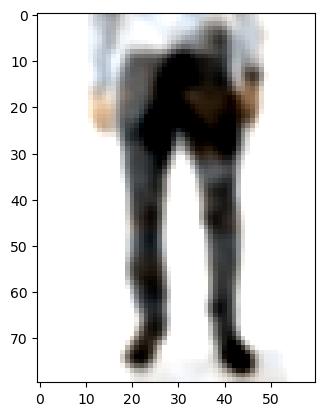

In [8]:
# Sample iteration
data, images, texts, labels = next(iter(test_loader))
plt.imshow(images[0].numpy().transpose((1,2,0)))
img = images[0]
print(texts[0])
print(labels[0].item())
print(data[0])

# Models

In [9]:
# CNN for image
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(13056,3256)
        self.fc2 = nn.Linear(3256,512)
        self.fc3 = nn.Linear(512, 27)

        # define proportion of neurons to dropout
        self.pool_dropout = nn.Dropout(0.25)
        self.layer_dropout = nn.Dropout(0.25)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool_dropout(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.pool_dropout(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.layer_dropout(x)
        x = F.relu(self.fc2(x))
        x = self.layer_dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

CNN_model = CNN().to(device)
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)

In [10]:
# DNN for categorical data

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 27)
        
        # define proportion of neurons to dropout
        self.layer_dropout = nn.Dropout(0.25)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.layer_dropout(x)
        x = F.relu(self.fc2(x))
        x = self.layer_dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

DNN_model = DNN().to(device)
DNN_optimizer = torch.optim.Adam(DNN_model.parameters(), lr=0.001)

In [11]:
# Helper functions for text classification
# Code snippet based on tutorial from PyTorch
tokenizer = get_tokenizer('basic_english')
regex = re.compile('[^a-zA-Z ]')

def yield_tokens(data_iter):
    for data, image, text, category in data_iter:
        keywords = []
        for t in text:
            t = regex.sub('', t)   # remove non alphabet chars
            t = re.sub(r"(\w)([A-Z])", r"\1 \2", t) # add space before capital letters
            t = ' '.join( [w for w in t.split() if len(w)>1] )   # remove single chars

            tokens = word_tokenize(t)
            tagged_tokens = nltk.pos_tag(tokens)

            # Iterate over the tagged tokens and extract keywords
            for token, tag in tagged_tokens:
                if tag.startswith('NN'):
                    # If the tag starts with NN (noun) add to list of keywords
                    keywords.append(token.lower())
        final_string = " ".join(keywords)
        yield tokenizer(final_string)

def process_text(text):
    text_list, offsets = [], [0]
    for t in text: 
        t = regex.sub('', t)   # remove non alphabet chars
        t = re.sub(r"(\w)([A-Z])", r"\1 \2", t) # add space before capital letters
        t = ' '.join( [w for w in t.split() if len(w)>1] )   # remove single chars
        
        tokens = word_tokenize(t)
        tagged_tokens = nltk.pos_tag(tokens)
        keywords = []
        for token, tag in tagged_tokens:
                if tag.startswith('NN'):
                    # If the tag starts with NN (noun) add to list of keywords
                    keywords.append(token.lower())
        t = " ".join(keywords)
        processed_text = torch.tensor(text_pipeline(t), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), offsets.to(device)

In [12]:
# build vocab
vocab = build_vocab_from_iterator(yield_tokens(train_loader), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [13]:
# Model for text
# Code snippets based on tutorial from PyTorch
class TextModel(nn.Module):
    def __init__(self):
        super(TextModel, self).__init__()
        self.embedding = nn.EmbeddingBag(len(vocab), 64, sparse=False)
        self.fc = nn.Linear(64, 27)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

text_model = TextModel().to(device)
text_optimizer = torch.optim.Adam(text_model.parameters(), lr=0.001)

# Train and Test Functions

In [14]:
loss_fn = nn.CrossEntropyLoss()

In [15]:
# Train function
def train(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    
    for batch, (categorical_data, images, text, categories) in enumerate(dataloader):
        categorical_data, images, text, categories = categorical_data.to(device), images.to(device), text, categories.to(device)
        
        # CNN 
        if (type(model).__name__ == 'CNN'):
            CNN_optimizer.zero_grad()
            pred = CNN_model(images)
            loss = loss_fn(pred, categories)
            loss.backward()
            CNN_optimizer.step()
            _, pred = torch.max(pred, 1)
        
        # DNN prediction
        elif (type(model).__name__ == 'DNN'):
            DNN_optimizer.zero_grad()
            pred = DNN_model(categorical_data.float())
            loss = loss_fn(pred, categories)
            loss.backward()
            DNN_optimizer.step()
            _, pred = torch.max(pred, 1)
        
        # Text
        else:
            text_optimizer.zero_grad()
            text, offsets = process_text(text)
            pred = text_model(text, offsets)
            loss = loss_fn(pred, categories)
            loss.backward()
            text_optimizer.step()
            _, pred = torch.max(pred, 1)
    
        train_loss += loss.item()
        correct += sum(x == y for x, y in zip(pred, categories))

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

In [16]:
# voting
def vote(image_pred, category_pred, text_pred):
    predictions = []
    for (i, c, t) in zip(image_pred, category_pred, text_pred):
        votes = set()
        for vote in [i, c, t]:
            if vote in votes:
                predictions.append(vote)
                break
            votes.add(vote.item())
        predictions.append(t.item())        
    return predictions

In [17]:
# Test
def test(dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    CNN_model.eval()
    DNN_model.eval()
    text_model.eval()
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for batch, (categorical_data, images, text, categories) in enumerate(dataloader):
                categorical_data, images, text, categories = categorical_data.to(device), images.to(device), text, categories.to(device)

                image_pred = CNN_model(images)
                _, image_pred = torch.max(image_pred, 1)

                category_pred = DNN_model(categorical_data.float())
                _, category_pred = torch.max(category_pred, 1)

                text, offsets = process_text(text)
                text_pred = text_model(text, offsets)
                _, text_pred = torch.max(text_pred, 1)

                final_pred = vote(image_pred, category_pred, text_pred)
                
                test_loss += loss_fn(torch.Tensor(final_pred).to(device), categories.float().to(device)).item()
                correct += sum(x == y for x, y in zip(final_pred, categories))
                
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

In [18]:
BATCH_SIZE = 64

def train_all(epochs=7):
  for t in tqdm(range(epochs)):
      print(f"Epoch {t+1}:")
    
      # produce training set and validation set
      train_size = int(len(train_set) * 0.9)
      test_size = int(len(train_set) - train_size)
      split_train, split_valid = random_split(train_set, [train_size, test_size])
      train_loader = DataLoader(split_train, batch_size=BATCH_SIZE, shuffle=True)
      valid_loader = DataLoader(split_valid, batch_size=BATCH_SIZE, shuffle=True)
      
      # train
      text_train_accuracy, text_average_train_loss = train(train_loader, text_model, loss_fn)
      CNN_train_accuracy, CNN_average_train_loss = train(train_loader, CNN_model, loss_fn)
      DNN_train_accuracy, DNN_average_train_loss = train(train_loader, DNN_model, loss_fn)
      print(f"\tAverage train accuracy: {100*CNN_train_accuracy:0.2f}% {100*DNN_train_accuracy:0.2f}% {100*text_train_accuracy:0.2f}%\t Avg train loss: {CNN_average_train_loss:>4f} {DNN_average_train_loss:>4f} {text_average_train_loss:>4f}\t")
    
      # test
      test_accuracy, test_loss = test(valid_loader, loss_fn)
      print(f"\tTest accuracy: {100*test_accuracy:0.2f}% \t Test loss: {test_loss:>4f}")

  return 

# Training

In [19]:
print('Training started')
train_all()
print('Training finished')

Training started


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
	Average train accuracy: 55.59% 33.74% 42.82%	 Avg train loss: 1.754116 2.531840 2.379717	


 14%|█▍        | 1/7 [03:08<18:51, 188.63s/it]

	Test accuracy: 53.86% 	 Test loss: 6149.220402
Epoch 2:
	Average train accuracy: 73.07% 36.65% 63.77%	 Avg train loss: 1.167750 2.311568 1.507050	


 29%|██▊       | 2/7 [06:07<15:14, 182.81s/it]

	Test accuracy: 71.15% 	 Test loss: 7188.354392
Epoch 3:
	Average train accuracy: 76.12% 38.68% 74.43%	 Avg train loss: 1.055784 2.200405 1.163259	


 43%|████▎     | 3/7 [09:07<12:05, 181.47s/it]

	Test accuracy: 76.19% 	 Test loss: 7418.795956
Epoch 4:
	Average train accuracy: 77.75% 39.16% 78.65%	 Avg train loss: 1.000922 2.138766 0.988141	


 57%|█████▋    | 4/7 [12:06<09:01, 180.47s/it]

	Test accuracy: 78.46% 	 Test loss: 7475.232235
Epoch 5:
	Average train accuracy: 79.07% 40.26% 80.80%	 Avg train loss: 0.937881 2.064839 0.894594	


 71%|███████▏  | 5/7 [15:04<05:59, 179.74s/it]

	Test accuracy: 81.14% 	 Test loss: 7718.533936
Epoch 6:
	Average train accuracy: 79.86% 41.29% 82.07%	 Avg train loss: 0.899268 2.013670 0.826320	


 86%|████████▌ | 6/7 [18:04<02:59, 179.92s/it]

	Test accuracy: 83.13% 	 Test loss: 7655.239488
Epoch 7:
	Average train accuracy: 80.67% 42.03% 83.55%	 Avg train loss: 0.853877 1.966326 0.758858	


100%|██████████| 7/7 [21:05<00:00, 180.74s/it]

	Test accuracy: 82.02% 	 Test loss: 7612.355368
Training finished


In [20]:
# produce training set and validation set
train_size = int(len(train_set) * 0.9)
test_size = int(len(train_set) - train_size)
split_train, split_valid = random_split(train_set, [train_size, test_size])
train_loader = DataLoader(split_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(split_valid, batch_size=64, shuffle=True)

In [21]:
torch.save(CNN_model, 'CNN_model.pt')
torch.save(DNN_model, 'DNN_model.pt')
torch.save(text_model, 'text_model.pt')

# Make predictions for test and submit

In [22]:
CNN_model = torch.load('CNN_model.pt')
DNN_model = torch.load('DNN_model.pt')
text_model = torch.load('text_model.pt')

In [23]:
# Predict
def predict(dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    CNN_model.eval()
    DNN_model.eval()
    text_model.eval()
    
    outputs = []
    
    with torch.no_grad():
        for batch, (categorical_data, images, text, categories) in enumerate(dataloader):
            categorical_data, images, text, categories = categorical_data.to(device), images.to(device), text, categories.to(device)
            
            image_pred = CNN_model(images)
            _, image_pred = torch.max(image_pred, 1)
            
            category_pred = DNN_model(categorical_data.float())
            _, category_pred = torch.max(category_pred, 1)
            
            text, offsets = process_text(text)
            text_pred = text_model(text, offsets)
            _, text_pred = torch.max(text_pred, 1)
            
            final_pred = vote(image_pred, category_pred, text_pred)
            
            outputs.append(final_pred[0])
    
    return torch.Tensor(outputs).to(device)

In [24]:
predictions = predict(test_loader, loss_fn)

processed_predictions = predictions.cpu().numpy().astype(int)
mapped_predictions = [category_map[y] for y in processed_predictions]

In [25]:
submission = pd.DataFrame({'id': test_df.id, 'category': mapped_predictions})
submission.to_csv('submission.csv', index=False)